<a href="https://colab.research.google.com/github/Tanushree-233/Stock_Price_Predictor/blob/main/Stock_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
df = pd.read_csv('/content/Amazon.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

data = df[['Close']]

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [7]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data)

In [8]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(60,1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 5.4635e-04
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 1.0434e-05
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 1.1143e-05
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 9.7458e-06
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 8.2123e-06
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 8.1509e-06
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 9.1295e-06
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 7.1768e-06
Epoch 9/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - loss: 8.1294e-06
Epoch 10/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 7.0912e-06


In [11]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scaling
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [12]:
rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
print("RMSE:", rmse)

RMSE: 108.91257749217449


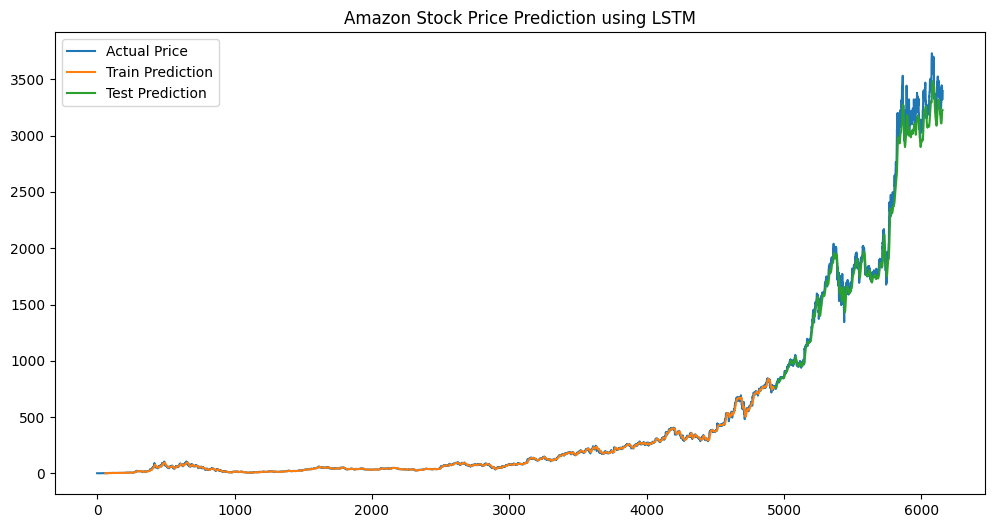

In [13]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Actual Price')

# Plot predictions
train_plot = np.empty_like(scaled_data)
train_plot[:] = np.nan
train_plot[60:train_size+60] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:] = np.nan
test_plot[train_size+60:] = test_predict

plt.plot(train_plot, label='Train Prediction')
plt.plot(test_plot, label='Test Prediction')

plt.legend()
plt.title("Amazon Stock Price Prediction using LSTM")
plt.show()